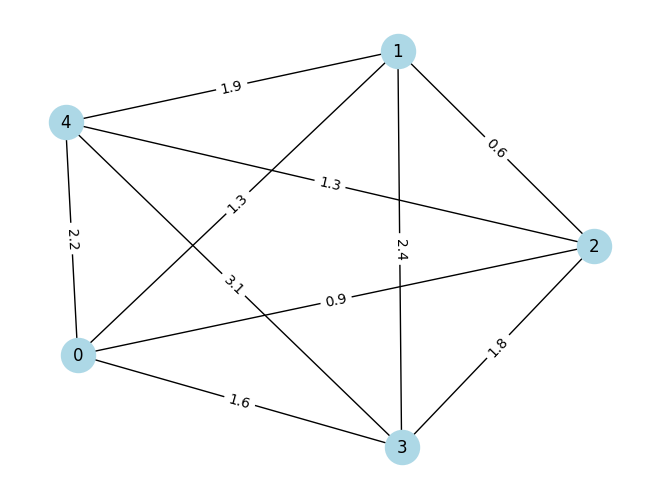

In [1]:
### =============================================================================
### 1) Imports & Setup
### =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister
from qiskit.circuit.library import QAOAAnsatz, IGate, XGate, YGate, ZGate, CXGate, ECRGate
from qiskit.dagcircuit import DAGCircuit
from qiskit.quantum_info import SparsePauliOp, Operator, pauli_basis
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import circuit_to_dag, dag_to_circuit

import random
import time
from typing import Optional, List, Iterable

### =============================================================================
### 2) Problem Definition: TSP Graph
### =============================================================================
cities = ["A", "B", "C", "D", "E"]
distance_matrix = np.array([
    [0,   1.3, 0.9, 1.6, 2.2],
    [1.3, 0,   0.6, 2.4, 1.9],
    [0.9, 0.6, 0,   1.8, 1.3],
    [1.6, 2.4, 1.8, 0,   3.1],
    [2.2, 1.9, 1.3, 3.1, 0]
])

graph = rx.PyGraph()
graph.add_nodes_from(range(len(cities)))
for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        graph.add_edge(i, j, distance_matrix[i][j])

draw_graph(graph, node_size=600, with_labels=True, node_color='lightblue', edge_labels=lambda w: f"{w:.1f}")
plt.show()


In [2]:
### =============================================================================
### 3) Hamiltonian Construction
### =============================================================================
def build_tsp_hamiltonian(graph: rx.PyGraph, penalty: float = 1000) -> SparsePauliOp:
    n = len(graph.nodes())
    terms = []

    for i in range(n):
        base = ["I"] * (n * n)
        for t in range(n):
            base[i * n + t] = "Z"
        terms.append(("".join(base), penalty * (1 - 2 / n)))

    for t in range(n):
        base = ["I"] * (n * n)
        for i in range(n):
            base[i * n + t] = "Z"
        terms.append(("".join(base), penalty * (1 - 2 / n)))

    for i, j, w in graph.weighted_edge_list():
        for t in range(n):
            base = ["I"] * (n * n)
            base[i * n + t] = "Z"
            base[j * n + ((t + 1) % n)] = "Z"
            terms.append(("".join(base), w / 4))

    return SparsePauliOp.from_list(terms)

tsp_hamiltonian = build_tsp_hamiltonian(graph)

### =============================================================================
### 4) QAOA Circuit
### =============================================================================
reps = 2
qaoa = QAOAAnsatz(cost_operator=tsp_hamiltonian, reps=reps)
init_angles = np.random.rand(qaoa.num_parameters)
qc = qaoa.assign_parameters(init_angles, inplace=False)
qc.measure_all()

### =============================================================================
### 5) Setup IBM Backend & Noise Model
### =============================================================================
service = QiskitRuntimeService()
dev = service.backend('ibm_brisbane')
seed_sim = 42
noisy_fake_backend = AerSimulator.from_backend(dev, seed_simulator=seed_sim)

# Error thresholds
max_readout_error = 0.015
max_single_gate_error = 0.01
max_cx_error = 0.03

Noise_dict, read_err, single_gate_errors, two_q_error_map = {}, [0]*dev.num_qubits, [0]*dev.num_qubits, {}
for gate, prop_dict in noisy_fake_backend.target.items():
    if prop_dict is None:
        continue
    for qargs, inst_props in prop_dict.items():
        if inst_props is None or inst_props.error is None:
            continue
        if gate == "measure":
            read_err[qargs[0]] = inst_props.error
        elif len(qargs) == 1:
            single_gate_errors[qargs[0]] = max(single_gate_errors[qargs[0]], inst_props.error)
        elif len(qargs) == 2:
            two_q_error_map[qargs] = max(two_q_error_map.get(qargs, 0), inst_props.error)

good_qubits = [q for q in range(dev.num_qubits) if read_err[q] <= max_readout_error and single_gate_errors[q] <= max_single_gate_error]
good_cx_edges = [q for q, err in two_q_error_map.items() if err <= max_cx_error and q[0] in good_qubits and q[1] in good_qubits]
bad_qubits = [q for q in range(dev.num_qubits) if q not in good_qubits]

print(f"Good qubits: {good_qubits}")
print(f"Bad qubits: {bad_qubits}")

C:\Users\abhis\AppData\Local\Temp\ipykernel_34808\1023660481.py:43: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


Good qubits: [2, 5, 6, 7, 10, 16, 19, 21, 23, 28, 30, 31, 32, 35, 40, 42, 47, 52, 58, 61, 62, 63, 65, 69, 71, 75, 76, 78, 85, 90, 97, 98, 99, 103, 105, 110, 111, 113, 116, 118, 124, 125]
Bad qubits: [0, 1, 3, 4, 8, 9, 11, 12, 13, 14, 15, 17, 18, 20, 22, 24, 25, 26, 27, 29, 33, 34, 36, 37, 38, 39, 41, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 64, 66, 67, 68, 70, 72, 73, 74, 77, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 100, 101, 102, 104, 106, 107, 108, 109, 112, 114, 115, 117, 119, 120, 121, 122, 123, 126]


In [3]:
### =============================================================================
### 6) Custom Conditional Pauli Twirl Pass
### =============================================================================
class ConditionalPauliTwirlPass(TransformationPass):
    def __init__(self, bad_qubits: List[int]):
        super().__init__()
        self.bad_qubits = set(bad_qubits)

    def _random_pauli(self):
        return random.choice([IGate(), XGate(), YGate(), ZGate()])

    def run(self, dag: DAGCircuit) -> DAGCircuit:
        new_dag = DAGCircuit()
        new_dag.add_qreg(dag.qregs['q'])
        if dag.cregs:
            for creg in dag.cregs.values():
                new_dag.add_creg(creg)

        for node in dag.topological_op_nodes():
            if node.op.name == "cx":
                ctrl, tgt = node.qargs
                if ctrl.index in self.bad_qubits or tgt.index in self.bad_qubits:
                    p1, p2 = self._random_pauli(), self._random_pauli()
                    p1_inv, p2_inv = p1.inverse(), p2.inverse()
                    new_dag.apply_operation_back(p1, [ctrl])
                    new_dag.apply_operation_back(p2, [tgt])
                    new_dag.apply_operation_back(node.op, [ctrl, tgt])
                    new_dag.apply_operation_back(p1_inv, [ctrl])
                    new_dag.apply_operation_back(p2_inv, [tgt])
                else:
                    new_dag.apply_operation_back(node.op, [ctrl, tgt])
            else:
                new_dag.apply_operation_back(node.op, node.qargs, node.cargs)
        return new_dag
# =============================================================================
# 7) Generic Pauli Twirl for Two-Qubit Gates (Corrected with Transpilation)
# =============================================================================

from qiskit.transpiler import PassManager, TransformationPass
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.circuit import QuantumRegister
from qiskit.quantum_info import Operator, Pauli
from qiskit import transpile
from typing import Optional, Iterable
import numpy as np
import matplotlib.pyplot as plt
import time

# Utility function: Pauli basis for N qubits
def pauli_basis(n):
    single_qubit_paulis = [Pauli("I"), Pauli("X"), Pauli("Y"), Pauli("Z")]
    if n == 1:
        return single_qubit_paulis
    from itertools import product
    return [Pauli("".join(p[::-1])) for p in product("IXYZ", repeat=n)]  # reverse for Qiskit ordering

# PauliTwirl class
class PauliTwirl(TransformationPass):
    def __init__(self, gates_to_twirl: Optional[Iterable] = None):
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()

    def build_twirl_set(self):
        self.twirl_set = {}
        for gate in self.gates_to_twirl:
            twirl_list = []
            for p1 in pauli_basis(2):
                for p2 in pauli_basis(2):
                    if (Operator(p1) @ Operator(gate)).equiv(Operator(gate) @ Operator(p2)):
                        twirl_list.append((p1, p2))
            self.twirl_set[gate.name] = twirl_list

    def run(self, dag: DAGCircuit) -> DAGCircuit:
        twirl_classes = tuple(g.base_class for g in self.gates_to_twirl)
        for node in dag.op_nodes():
            if not isinstance(node.op, twirl_classes):
                continue
            idx = np.random.randint(0, len(self.twirl_set[node.op.name]))
            left, right = self.twirl_set[node.op.name][idx]

            mini_dag = DAGCircuit()
            reg = QuantumRegister(2)
            mini_dag.add_qreg(reg)
            mini_dag.apply_operation_back(left.to_instruction(), [reg[0], reg[1]])
            mini_dag.apply_operation_back(node.op, [reg[0], reg[1]])
            mini_dag.apply_operation_back(right.to_instruction(), [reg[0], reg[1]])

            dag.substitute_node_with_dag(node, mini_dag)
        return dag



Level 0: Time = 0.064s, Depth = 3695
Level 1: Time = 0.080s, Depth = 1431
Level 2: Time = 0.151s, Depth = 1507
Level 3: Time = 0.272s, Depth = 1536


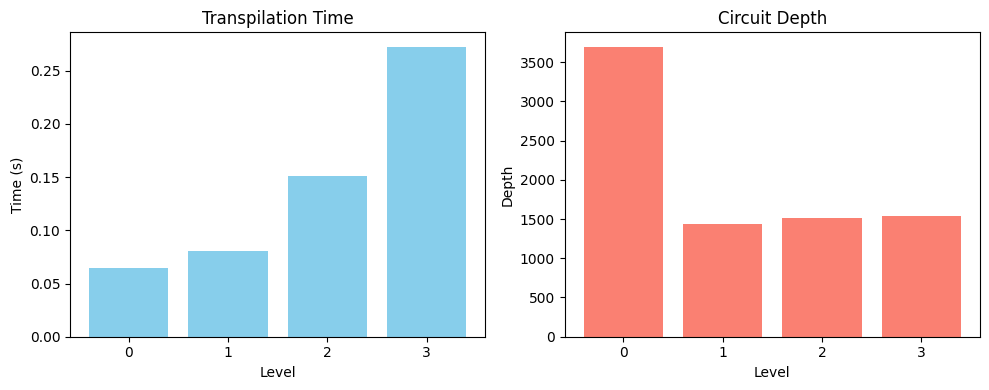

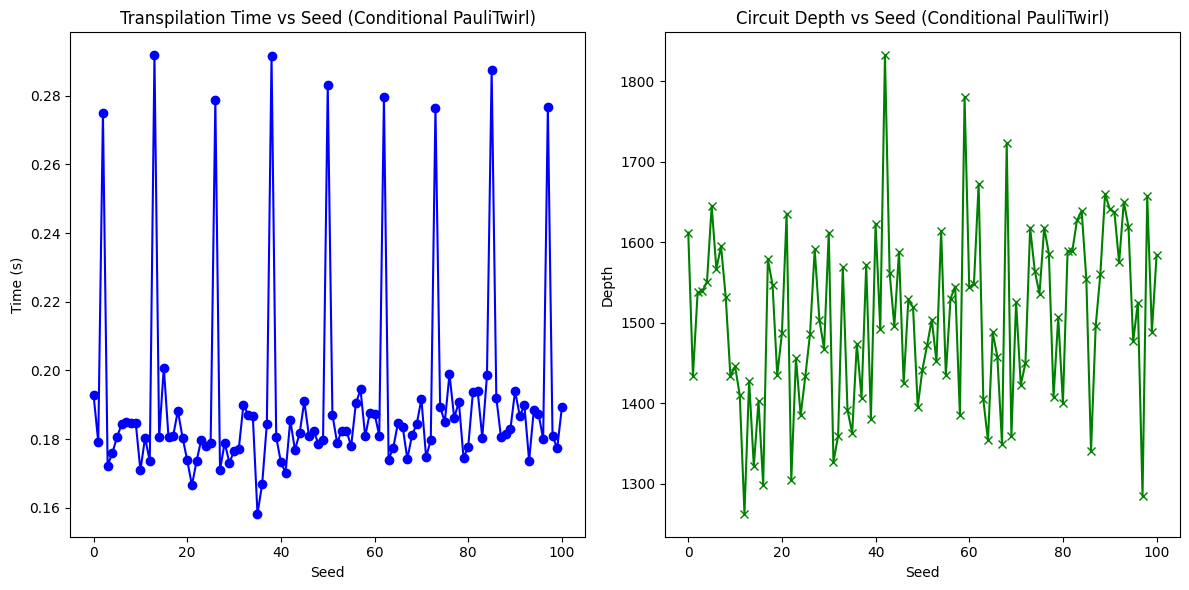

Best transpiler seed (Conditional PauliTwirl): 12, Depth: 1263


C:\Users\abhis\AppData\Local\Temp\ipykernel_34808\4044277921.py:83: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  pauli_count = sum(1 for inst, _, _ in twirled_qc.data if inst.name in ['x', 'y', 'z'])


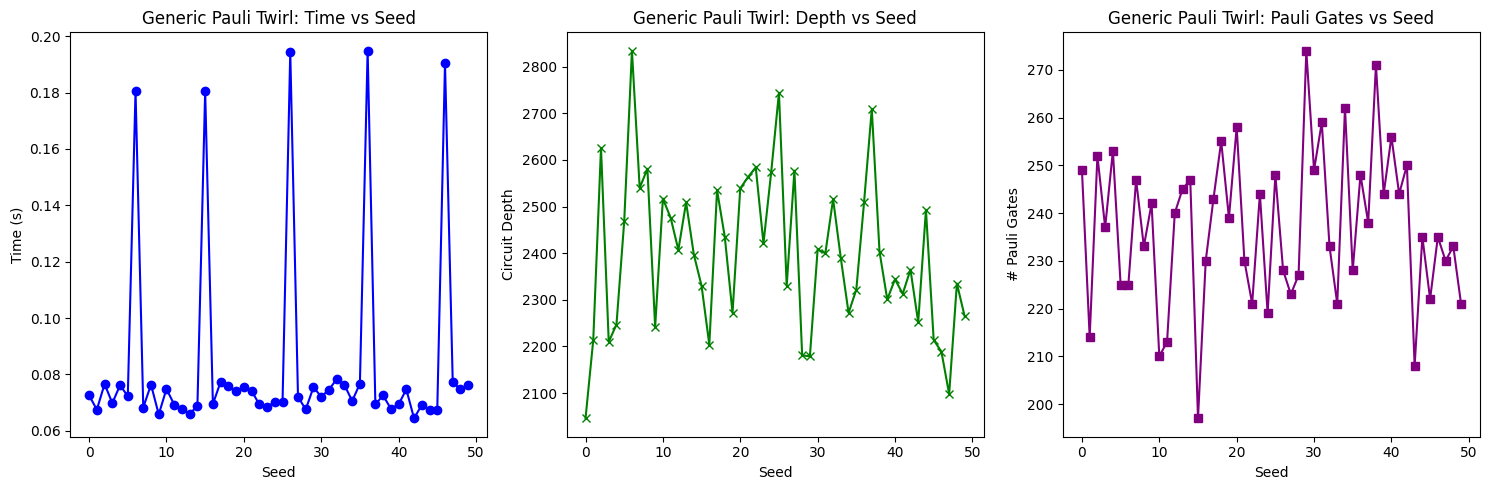

Best seed (Generic PauliTwirl): 0, Depth: 2046, Pauli gates inserted: 249


In [4]:
### =============================================================================
### 8) Transpilation Benchmarking
### =============================================================================
optimization_levels = [0, 1, 2, 3]
times, depths = [], []

for level in optimization_levels:
    pm = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=level)
    start = time.time()
    out = pm.run(qc)
    times.append(time.time() - start)
    depths.append(out.depth())
    print(f"Level {level}: Time = {times[-1]:.3f}s, Depth = {depths[-1]}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar([str(lvl) for lvl in optimization_levels], times, color='skyblue')
plt.title('Transpilation Time'); plt.xlabel('Level'); plt.ylabel('Time (s)')

plt.subplot(1, 2, 2)
plt.bar([str(lvl) for lvl in optimization_levels], depths, color='salmon')
plt.title('Circuit Depth'); plt.xlabel('Level'); plt.ylabel('Depth')
plt.tight_layout(); plt.show()

### =============================================================================
### 9) Benchmarking with Conditional Pauli Twirl
### =============================================================================
twirl_pass = ConditionalPauliTwirlPass(bad_qubits)
seed_values = list(range(101))
times, depths = [], []

for seed in seed_values:
    start = time.time()

    pm = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=2, seed_transpiler=seed)
    transpiled = pm.run(qc)
    twirled_dag = twirl_pass.run(circuit_to_dag(transpiled))
    twirled_circuit = dag_to_circuit(twirled_dag)

    times.append(time.time() - start)
    depths.append(twirled_circuit.depth())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(seed_values, times, marker='o', linestyle='-', color='blue')
plt.title('Transpilation Time vs Seed (Conditional PauliTwirl)')
plt.xlabel('Seed'); plt.ylabel('Time (s)')

plt.subplot(1, 2, 2)
plt.plot(seed_values, depths, marker='x', linestyle='-', color='green')
plt.title('Circuit Depth vs Seed (Conditional PauliTwirl)')
plt.xlabel('Seed'); plt.ylabel('Depth')

plt.tight_layout()
plt.show()

best_idx = depths.index(min(depths))
print(f"Best transpiler seed (Conditional PauliTwirl): {seed_values[best_idx]}, Depth: {depths[best_idx]}")


# =============================================================================
# 10) Benchmarking with Generic Pauli Twirl
# =============================================================================
generic_twirl_times, generic_twirl_depths, generic_twirl_paulis = [], [], []
seed_values = list(range(50))

twirl_pm = PassManager([PauliTwirl()])

for seed in seed_values:
    np.random.seed(seed)

    # --- Transpile to expose CX/ECR gates ---
    transpiled_qc = transpile(qc, backend=noisy_fake_backend, optimization_level=1)

    # --- Apply PauliTwirl ---
    start = time.time()
    twirled_qc = twirl_pm.run(transpiled_qc)
    duration = time.time() - start

    # --- Measure results ---
    generic_twirl_times.append(duration)
    generic_twirl_depths.append(twirled_qc.depth())
    pauli_count = sum(1 for inst, _, _ in twirled_qc.data if inst.name in ['x', 'y', 'z'])
    generic_twirl_paulis.append(pauli_count)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(seed_values, generic_twirl_times, marker='o', color='blue')
plt.title('Generic Pauli Twirl: Time vs Seed')
plt.xlabel('Seed'); plt.ylabel('Time (s)')

plt.subplot(1, 3, 2)
plt.plot(seed_values, generic_twirl_depths, marker='x', color='green')
plt.title('Generic Pauli Twirl: Depth vs Seed')
plt.xlabel('Seed'); plt.ylabel('Circuit Depth')

plt.subplot(1, 3, 3)
plt.plot(seed_values, generic_twirl_paulis, marker='s', color='purple')
plt.title('Generic Pauli Twirl: Pauli Gates vs Seed')
plt.xlabel('Seed'); plt.ylabel('# Pauli Gates')

plt.tight_layout()
plt.show()

# Summary
best_idx = generic_twirl_depths.index(min(generic_twirl_depths))
print(f"Best seed (Generic PauliTwirl): {seed_values[best_idx]}, "
      f"Depth: {generic_twirl_depths[best_idx]}, "
      f"Pauli gates inserted: {generic_twirl_paulis[best_idx]}")

